# Tweet Sentiment Analysis

In [152]:
# import libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re
import random
import pydot
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')

from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import networkx as nx

[nltk_data] Downloading package stopwords to /home/david/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/david/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# load data
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1') # use encoding='latin-1' to debug UnicodeDecodeError 
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


## Introduction
**Based on the previous descriptive analysis of the Twitter dataset, it was observed that the core feature for sentiment classification is the tweet text itself. While various factors like word frequency and readability provided insights into user behavior, the primary predictor for the upcoming machine learning analysis will be the cleaned tweet text. The goal is to understand how the content of the text relates to the sentiment (positive or negative). To ensure that the model can effectively learn from the text data, preprocessing steps like tokenization, stopword removal, and TF-IDF vectorization will be employed to convert the raw text into numerical features suitable for prediction.**

In [3]:
# rename columns
df.columns = ['target', 'ids', 'data', 'flag', 'user', 'text'] 
df.head()

,target,ids,data,flag,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
# map target column: 0(negative), 1(positive) for readability
df['target'] = df['target'].map({0: 0, 4: 1})

# delete unrelated columns
df = df.drop(columns=['ids', 'flag', 'user'])

# modify data column
# remove the timezone identifier 
df['data'] = df['data'].apply(lambda x: re.sub(r' [A-Z]{3}', '', x))

# change date format
df['data'] = pd.to_datetime(df['data'], errors='coerce')

# set timezone to UTC
df['data'] = df['data'].dt.tz_localize('America/Los_Angeles').dt.tz_convert('UTC')
df.head()

,target,data,text
0,0,2009-04-07 05:19:49+00:00,is upset that he can't update his Facebook by ...
1,0,2009-04-07 05:19:53+00:00,@Kenichan I dived many times for the ball. Man...
2,0,2009-04-07 05:19:57+00:00,my whole body feels itchy and like its on fire
3,0,2009-04-07 05:19:57+00:00,"@nationwideclass no, it's not behaving at all...."
4,0,2009-04-07 05:20:00+00:00,@Kwesidei not the whole crew


In [5]:
# clean text
def clean_tweet(text):
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)     # remove mentions
    text = re.sub(r'#\w+', '', text)     # remobe hashtags
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text)     # remove extra spaces
    return text.lower().strip()          # remove leading/trailing spaces

df['clean_text'] = df['text'].apply(clean_tweet)

In [6]:
# tokenize and remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    return ' '.join([word for word in words if word not in stop_words])
df['clean_text'] = df['clean_text'].apply(remove_stopwords)

In [7]:
# stemming

# initialize Porter Stemmer object
ps = PorterStemmer()

# generate the stem of each word 
df['clean_text'] = df['clean_text'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split()]))

In [8]:
# initiate a TfidfVectorizer object
vectorizer = TfidfVectorizer(max_features=5000)

# Convert the text data into a numerical feature matrix
X = vectorizer.fit_transform(df['clean_text'])
y = df['target']

In [10]:
# using stratified sampling to ensure that the sentiment class distribution in the data subset is consistent with the originla dataset
df_sample, _ = train_test_split(df, test_size=0.9, stratify=df['target'], random_state=42)
X_sample = vectorizer.fit_transform(df_sample['clean_text'])
y_sample = df_sample['target']

#split train, test data
X_sample_train, X_sample_test, y_sample_train, y_sample_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

In [11]:
# class distribution of the original dataset
print(df['target'].value_counts(normalize=True))

# class distribution of the sample dataset
print(df_sample['target'].value_counts(normalize=True))

target
1    0.5
0    0.5
Name: proportion, dtype: float64
target
1    0.500003
0    0.499997
Name: proportion, dtype: float64


Scaling (Standardization): Since I’m working with text data that has been vectorized using TF-IDF, which inherently handles feature scaling, further standardization does not appear necessary.

Cross-validation: Given my relatively large dataset (128,000 training samples and 32,000 test samples), cross-validation, though valuable in smaller datasets, may not provide significant additional benefits and would increase computation time without a clear performance gain.

Pipeline: Since I'm not performing multiple transformations (such as scaling or feature selection), the need for a pipeline also seems minimal, as I'm directly applying models like SVM, Logistic Regression, etc.

In [12]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
    """
    evaluate model performance and return calssification report

    Parameters:
    X_train, y_train: trained data
    X_test, y_test: tested data
    model: model need to be evaluated(such as LogisticRegresison(), RandomForestClassifier())

    Returns:
    report_str(str): Classification report in string format
    report_dict(dict): Classification report in dictionary format
    """
    # train the model
    model.fit(X_train, y_train)

    # predict
    y_pred = model.predict(X_test)

    #generate classification report
    report_str = classification_report(y_test, y_pred)
    report_dict = classification_report(y_test, y_pred, output_dict=True)

    return report_str, report_dict

# evaluate models and extract reports
logreg_report_str, logreg_report_dict = evaluate_model(X_sample_train, y_sample_train, X_sample_test, y_sample_test, LogisticRegression())
rf_report_str, rf_report_dict = evaluate_model(X_sample_train, y_sample_train, X_sample_test, y_sample_test, RandomForestClassifier())
svm_report_str, svm_report_dict = evaluate_model(X_sample_train, y_sample_train, X_sample_test, y_sample_test, SVC())
nb_report_str, nb_report_dict = evaluate_model(X_sample_train, y_sample_train, X_sample_test, y_sample_test, MultinomialNB())

# output the classification reports
print('Logistic Regression Report:\n', logreg_report_str)
print('Random Forest Report:\n', rf_report_str)
print('Support Vector Machine Report:\n', svm_report_str)
print('Naive Bayes Report:\n', nb_report_str)

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76     15974
           1       0.76      0.78      0.77     16026

    accuracy                           0.76     32000
   macro avg       0.77      0.76      0.76     32000
weighted avg       0.77      0.76      0.76     32000

Random Forest Report:
               precision    recall  f1-score   support

           0       0.75      0.76      0.76     15974
           1       0.76      0.75      0.75     16026

    accuracy                           0.75     32000
   macro avg       0.75      0.75      0.75     32000
weighted avg       0.75      0.75      0.75     32000

Support Vector Machine Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76     15974
           1       0.76      0.79      0.77     16026

    accuracy                           0.77     32000
   macro avg       0.77      0.77      0.77 

In [15]:
# Extracting accuracy, precision, recall, and F1-score from the reports
metrics_data = {
    'Model': ['Logistic Regression', 'Random Forest', 'Support Vector Machine', 'Naive Bayes'],
    'Accuracy': [
        logreg_report_dict['accuracy'], 
        rf_report_dict['accuracy'], 
        svm_report_dict['accuracy'], 
        nb_report_dict['accuracy']
    ],
    'Precision': [
        logreg_report_dict['weighted avg']['precision'], 
        rf_report_dict['weighted avg']['precision'], 
        svm_report_dict['weighted avg']['precision'], 
        nb_report_dict['weighted avg']['precision']
    ],
    'Recall': [
        logreg_report_dict['weighted avg']['recall'], 
        rf_report_dict['weighted avg']['recall'], 
        svm_report_dict['weighted avg']['recall'], 
        nb_report_dict['weighted avg']['recall']
    ],
    'F1-score': [
        logreg_report_dict['weighted avg']['f1-score'], 
        rf_report_dict['weighted avg']['f1-score'], 
        svm_report_dict['weighted avg']['f1-score'], 
        nb_report_dict['weighted avg']['f1-score']
    ]
}

# Creating DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Displaying the DataFrame
metrics_df

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic Regression,0.764813,0.765196,0.764813,0.764717
1,Random Forest,0.753969,0.754011,0.753969,0.753962
2,Support Vector Machine,0.768813,0.769294,0.768813,0.768697
3,Naive Bayes,0.750844,0.751075,0.750844,0.750795


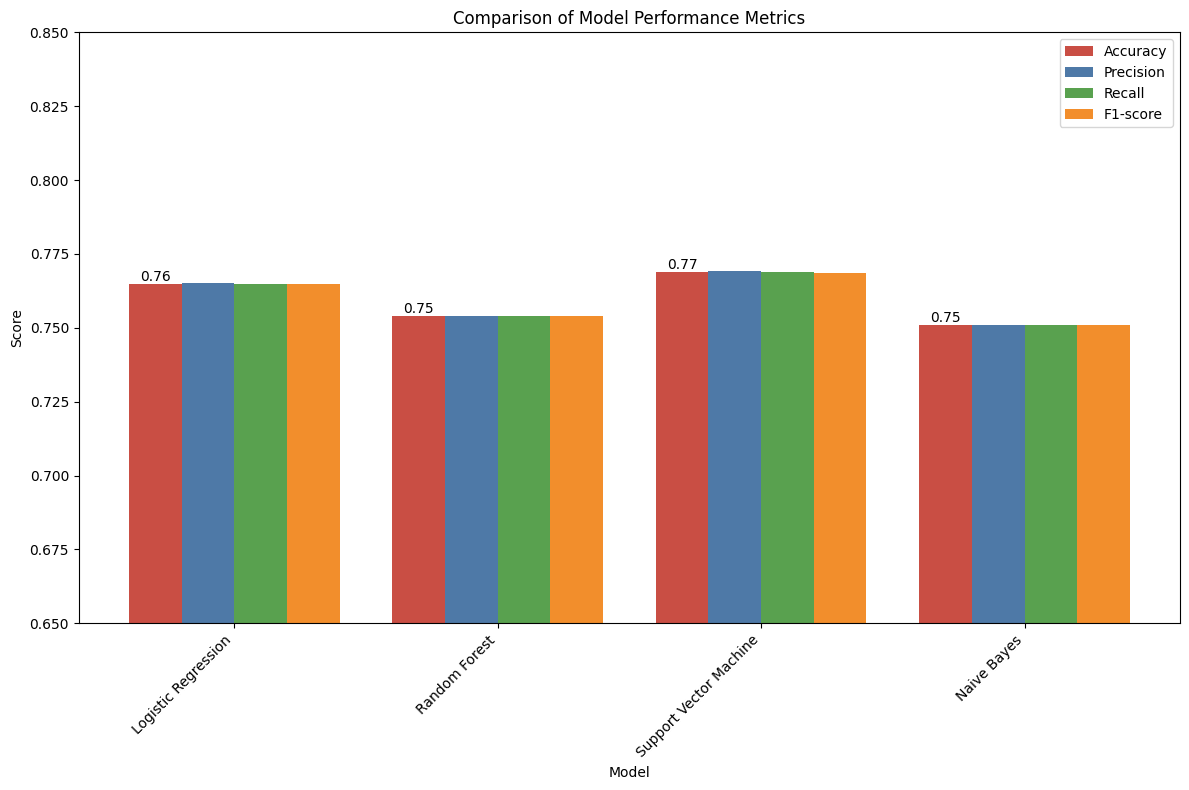

In [17]:
# visualize
plt.figure(figsize=(12, 8))

# generate x-axis location of each model
x = np.arange(len(metrics_df['Model']))

# set width
width = 0.2

# plot four different barplots - Accuracy、Precision、Recall and F1-score
accuracy_bar = plt.bar(x - 1.5*width, metrics_df['Accuracy'], width, label='Accuracy', color='#C94E44')
plt.bar(x - 0.5*width, metrics_df['Precision'], width, label='Precision', color='#4E79A7')
plt.bar(x + 0.5*width, metrics_df['Recall'], width, label='Recall', color='#59A14F')
plt.bar(x + 1.5*width, metrics_df['F1-score'], width, label='F1-score', color='#F28E2C')

# add accuracy to accuracy bar
for bar in accuracy_bar:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

# add title and labels
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Comparison of Model Performance Metrics')

# set x-axis location and title
plt.xticks(x, metrics_df['Model'], rotation=45, ha='right')

# set ylim
plt.ylim(0.65, 0.85)

# add legend
plt.legend()

plt.tight_layout()
plt.show()

**Based on the metrics above, Support Vector Machine (SVM) is the best-performing model, with both accuracy and macro average F1-score at 0.77, slightly outperforming the other models.**

In [ ]:
'''
Due to the excessive time required for Randomized Search, and the limited accuracy improvement that Grid Search is likely to provide, we have decided to skip Grid Search and proceed directly to deep learning methods for further analysis. 
This allows for a more efficient exploration of advanced models without spending additional time on marginal gains from hyperparameter tuning.
'''

In [100]:
# use SVM to do random search
# Split the sample training set into a smaller training set and validation set (80% train, 20% validation)
X_sample_train_split, X_sample_val_split, y_sample_train_split, y_sample_val_split = train_test_split(
    X_sample_train, y_sample_train, test_size=0.2, random_state=42
)

# Step 1: Use RandomizedSearchCV to determine the general range of parameters
param_distributions = {
    'C': np.logspace(-2, 2, 5),  # Range of C values (exponential scale)
    'gamma': ['scale', 0.001, 0.01],  # Range of gamma values
    'kernel': ['rbf']  # Testing only the RBF kernel
}

# Perform Randomized Search with 1 random combinations
random_search = RandomizedSearchCV(
    estimator=SVC(),
    param_distributions=param_distributions,
    n_iter=10,  # Test 10 random combinations
    verbose=0,  # Suppress progress display
    n_jobs=-1,  # Use all available processors
    random_state=42
)

# Train Randomized Search on the sample training set split
start_time = time.time()  # Start timing
random_search.fit(X_sample_train_split, y_sample_train_split)
end_time = time.time()  # End timing
print(f"Random Search Training Time: {end_time - start_time} seconds")  # Print training duration

# Output the best parameters from Randomized Search
best_params = random_search.best_params_
print("Random Search Best Parameters:", best_params)

Random Search Training Time: 8153.848955154419 seconds
Random Search Best Parameters: {'kernel': 'rbf', 'gamma': 0.01, 'C': 10.0}


In [115]:
# Gridsearch on SVM
# Best parameters from Random Search
best_params = {'kernel': 'rbf', 'gamma': 0.01, 'C': 10.0}

# Perform a Grid Search 
param_grid = {
    'C': [best_params['C'] * 0.5, best_params['C'], best_params['C'] * 1.5],  # Test around the best C from Random Search
    'gamma': [best_params['gamma'] * 0.1, best_params['gamma'], best_params['gamma'] * 10],  # Test around the best gamma
    'kernel': [best_params['kernel']]  # Fix kernel as 'rbf'
}

# GridSearchCV setup 
grid_search = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid,
    verbose=0,  # Suppress the output
    n_jobs=-1,  # Use all available cores for faster computation
)

# Train Grid Search on the sample training set
start_time = time.time()  # Start timing
grid_search.fit(X_sample_train_split, y_sample_train_split)
end_time = time.time()  # End timing
print(f"Grid Search Training Time: {end_time - start_time} seconds")  # Print training duration

# Output the best parameters from Grid Search
print("Grid Search Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
final_model = SVC(**grid_search.best_params_)
final_model.fit(X_sample_train_split, y_sample_train_split)

# Make predictions on the test set
y_test_pred = final_model.predict(X_sample_test)

# Output test set evaluation results
print("Test Set Accuracy:", accuracy_score(y_sample_test, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_sample_test, y_test_pred))

Grid Search Training Time: 6344.0498604774475 seconds
Grid Search Best Parameters: {'C': 5.0, 'gamma': 0.1, 'kernel': 'rbf'}
Test Set Accuracy: 0.76453125
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76     15974
           1       0.75      0.79      0.77     16026

    accuracy                           0.76     32000
   macro avg       0.77      0.76      0.76     32000
weighted avg       0.77      0.76      0.76     32000



**Model performance has actually decreased compared to the model without hyperparameter tuning.**

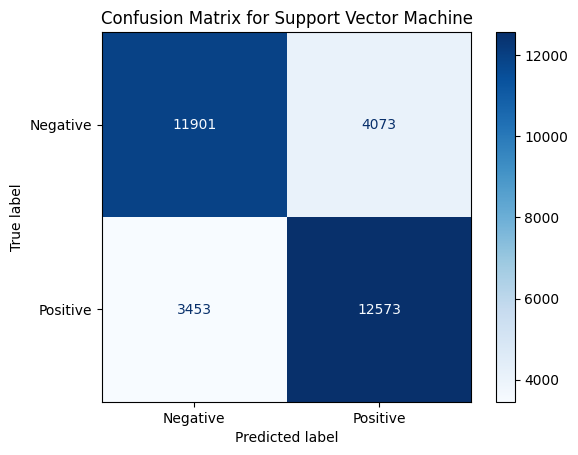

In [125]:
# plot the confusion matrix based on the best result so far

# get the predictions for the test set
svm = SVC()
svm.fit(X_sample_train, y_sample_train)
y_pred_svm = svm.predict(X_sample_test)

# generate confusion matrix
conf_matrix_svm = confusion_matrix(y_sample_test, y_pred_logreg)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_svm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Support Vector Machine')
plt.show()

**The confusion matrix for support vector machine shows that the model performs relatively well in identifying both negative and positive sentiments. It correctly classifies a large number of both positive and negative tweets, but there are still some misclassifications. The model tends to incorrectly predict some positive tweets as negative and vice versa. However, the overall performance indicates that the model is reasonably effective at distinguishing between negative and positive sentiments.**

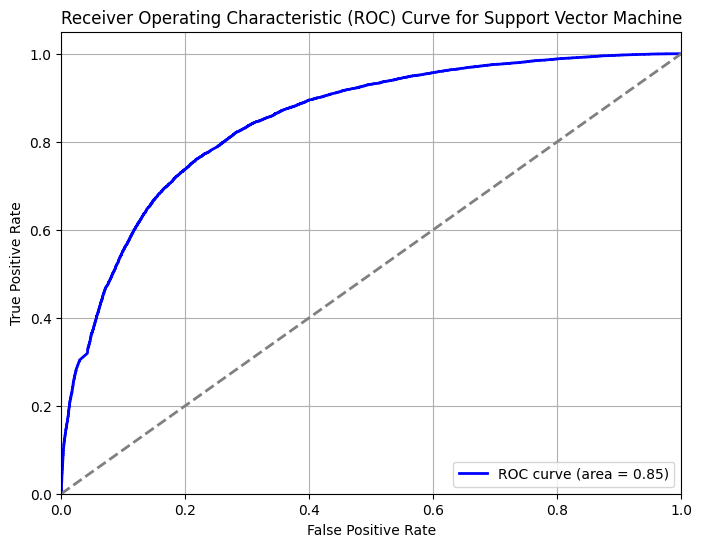

In [129]:
# plot roc curve on the best svm model so far

# get the predictions for the test set
svm = SVC(probability=True)
svm.fit(X_sample_train, y_sample_train)
y_pred_svm = svm.predict(X_sample_test)

# Get the predicted probabilities for the positive class
y_prob_svm = svm.predict_proba(X_sample_test)[:, 1]

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_sample_test, y_prob_svm)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Support Vector Machine')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**The ROC curve for the Support Vector Machine model shows an AUC (Area Under the Curve) of 0.85, which indicates a good level of discrimination, suggesting that the model performs well in distinguishing sentiment classes (positive and negative).**

In [38]:
# Split the sample training set into a smaller training set and validation set (80% train, 20% validation)
X_sample_train_split, X_sample_val_split, y_sample_train_split, y_sample_val_split = train_test_split(
    X_sample_train, y_sample_train, test_size=0.2, random_state=42
)

# Define the parameter distributions for RandomizedSearchCV
param_distributions = [
    {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l2'],
        'solver': ['lbfgs'],
        'max_iter': [500, 1000]
    },
    {
        'C': np.logspace(-4, 4, 20),
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [500, 1000]
    }
]

# Perform Randomized Search with Logistic Regression
random_search = RandomizedSearchCV(
    estimator=LogisticRegression(),
    param_distributions=param_distributions,
    n_iter=10,  # Test 10 random combinations
    verbose=0,  # Suppress the progress
    n_jobs=-1,  # Use all available processors
    random_state=42
)

# Train Randomized Search on the sample training set
random_search.fit(X_sample_train_split, y_sample_train_split)

# Output the best parameters from Randomized Search
best_params = random_search.best_params_
print("Random Search Best Parameters:", best_params)

Random Search Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'C': 0.615848211066026}


In [40]:
# Grid search on Logistic Regression

# Best parameters from Random Search
best_params = {'solver': 'saga', 'penalty': 'l2', 'max_iter': 500, 'C': 0.615848211066026}

# Perform a Grid Search 
param_grid = {
    'C': [best_params['C'] * 0.5, best_params['C'], best_params['C'] * 1.5],  # Test around the best C
    'solver': [best_params['solver']],  # Fix solver
    'penalty': [best_params['penalty']],  # Fix penalty
    'max_iter': [500, 1000]  # Test around max_iter
}

# GridSearchCV setup 
grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=param_grid,
    verbose=0,
    n_jobs=-1
)

# Train Grid Search on the sample training set
grid_search.fit(X_sample_train_split, y_sample_train_split)

# Output the best parameters from Grid Search
print("Grid Search Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
final_model = LogisticRegression(**grid_search.best_params_)
final_model.fit(X_sample_train_split, y_sample_train_split)

# Make predictions on the test set
y_test_pred = final_model.predict(X_sample_test)

# Output test set evaluation results
print("Test Set Accuracy:", accuracy_score(y_sample_test, y_test_pred))
print("Test Set Classification Report:\n", classification_report(y_sample_test, y_test_pred))

Grid Search Best Parameters: {'C': 0.615848211066026, 'max_iter': 500, 'penalty': 'l2', 'solver': 'saga'}
Test Set Accuracy: 0.76346875
Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76     15974
           1       0.75      0.78      0.77     16026

    accuracy                           0.76     32000
   macro avg       0.76      0.76      0.76     32000
weighted avg       0.76      0.76      0.76     32000



**Model performance has actually decreased compared to the model without hyperparameter tuning.**

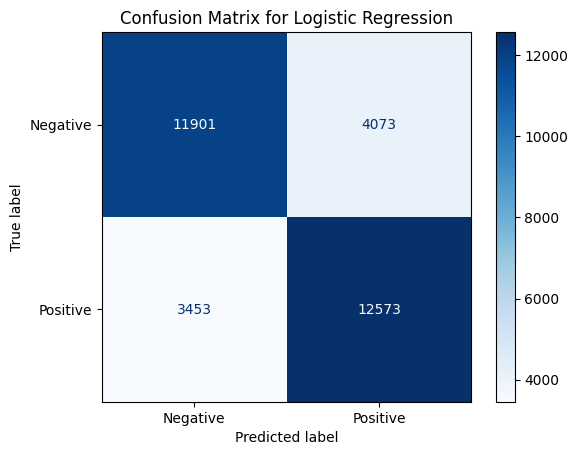

In [41]:
# plot the confusion matrix based on the best result so far

# get the predictions for the test set
logreg = LogisticRegression()
logreg.fit(X_sample_train, y_sample_train)
y_pred_logreg = logreg.predict(X_sample_test)

# generate confusion matrix
conf_matrix_logreg = confusion_matrix(y_sample_test, y_pred_logreg)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_logreg, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

**The confusion matrix for logistic regression shows that the model performs relatively well in identifying both negative and positive sentiments. It correctly classifies a large number of both positive and negative tweets, but there are still some misclassifications. The model tends to incorrectly predict some positive tweets as negative and vice versa. However, the overall performance indicates that the model is reasonably effective at distinguishing between negative and positive sentiments.**

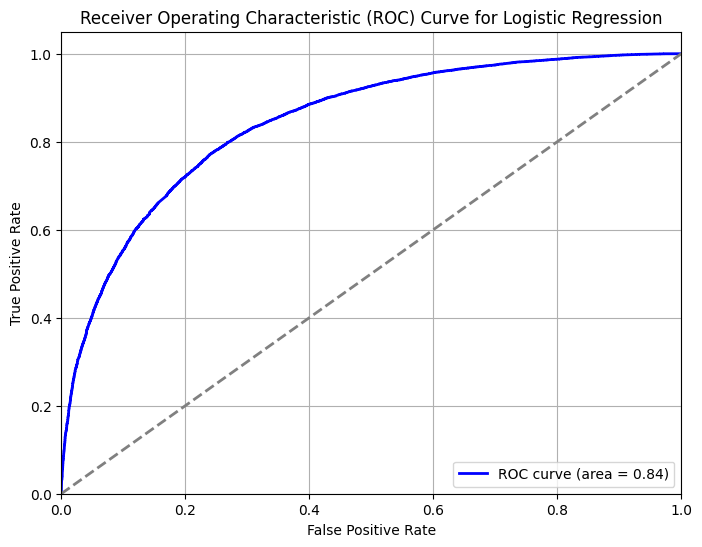

In [102]:
# Get the predicted probabilities for the positive class
y_prob_logreg = logreg.predict_proba(X_sample_test)[:, 1]

# Generate the ROC curve
fpr, tpr, thresholds = roc_curve(y_sample_test, y_prob_logreg)

# Compute the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

**The ROC curve for the Logistic Regression model shows an AUC (Area Under the Curve) of 0.84, which indicates a good level of discrimination, suggesting that the model performs well in distinguishing sentiment classes (positive and negative).**

*The best models for SVM and Logistic Regression were not applied to the entire dataset, because the full dataset is too large, and time constraints do not allow for this step.*

In [87]:
'''
Neural network part.
'''
# Step 1: Tokenize the text and convert it into sequences
max_vocab_size = 10000  
max_sequence_length = 100  # Max tweet length (100 words)

tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(df['clean_text'])  # Fit on the cleaned text

X = tokenizer.texts_to_sequences(df['clean_text'])  # Convert text to sequences
X = pad_sequences(X, maxlen=max_sequence_length)  # Pad sequences to ensure equal length

# Step 2: Encode the target labels (0 for negative, 1 for positive)
y = df['target'].values

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Build the TextCNN model
embedding_dim = 100  # Size of the embedding layer
num_filters = 128    # Number of filters for each Conv1D layer
kernel_size = 5      # Window size for convolution
dropout_rate = 0.5   # Dropout rate to avoid overfitting

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
batch_size = 32
epochs = 10  

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

# Step 7: Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 934us/step - accuracy: 0.7845 - loss: 0.4646
Test Accuracy: 0.7836531400680542


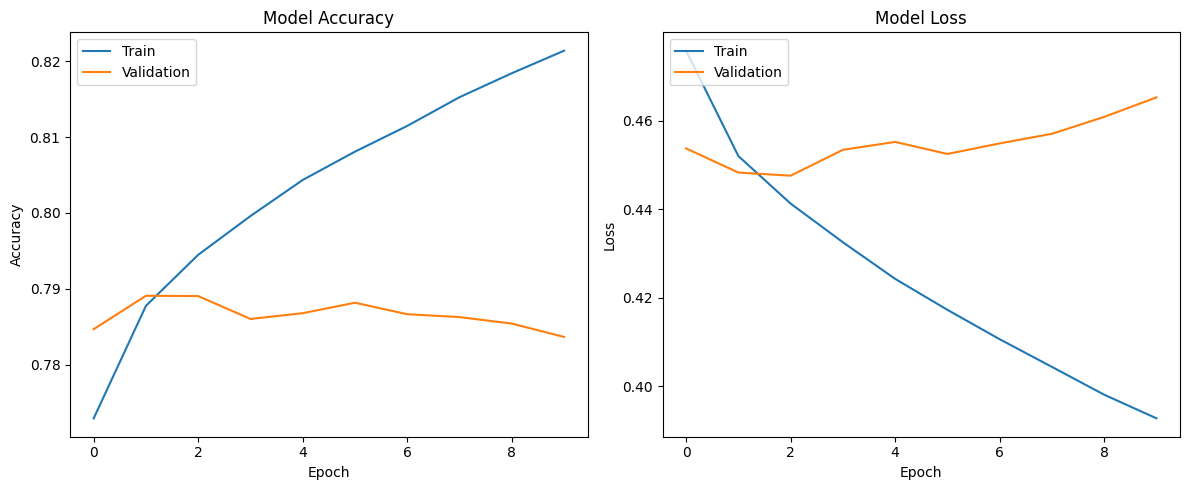

In [88]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**From the validation curve, we can tell the model is overfitting.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 922us/step - accuracy: 0.7851 - loss: 0.4689
Test Accuracy: 0.7837749719619751


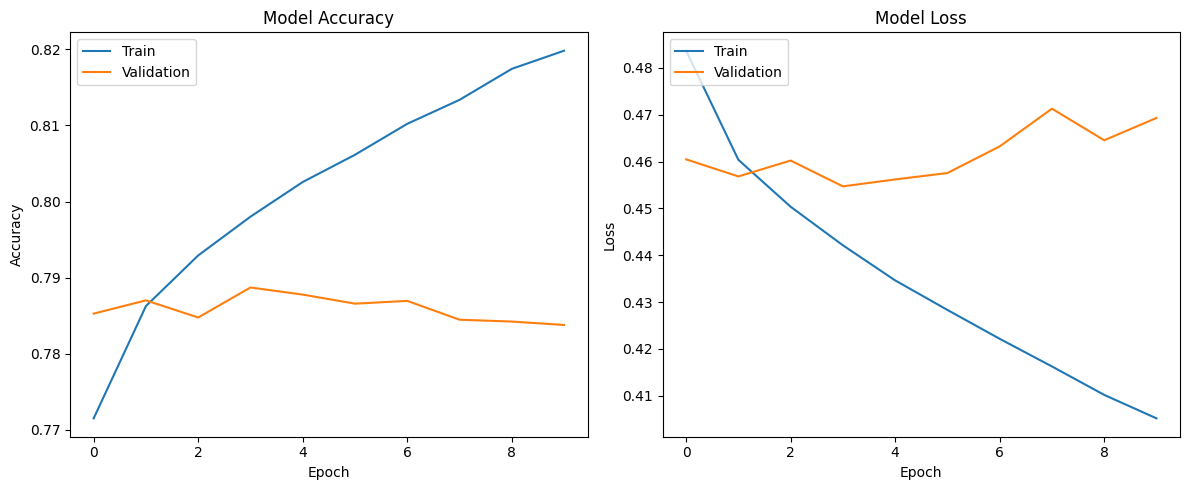

In [89]:
# add Regularization to prevent overfitting

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(dropout_rate))
model.add(Dense(10, activation='relu', kernel_regularizer='l2')) # L2 Regularization
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Still overfits**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 902us/step - accuracy: 0.7783 - loss: 0.5015
Test Accuracy: 0.7783874869346619


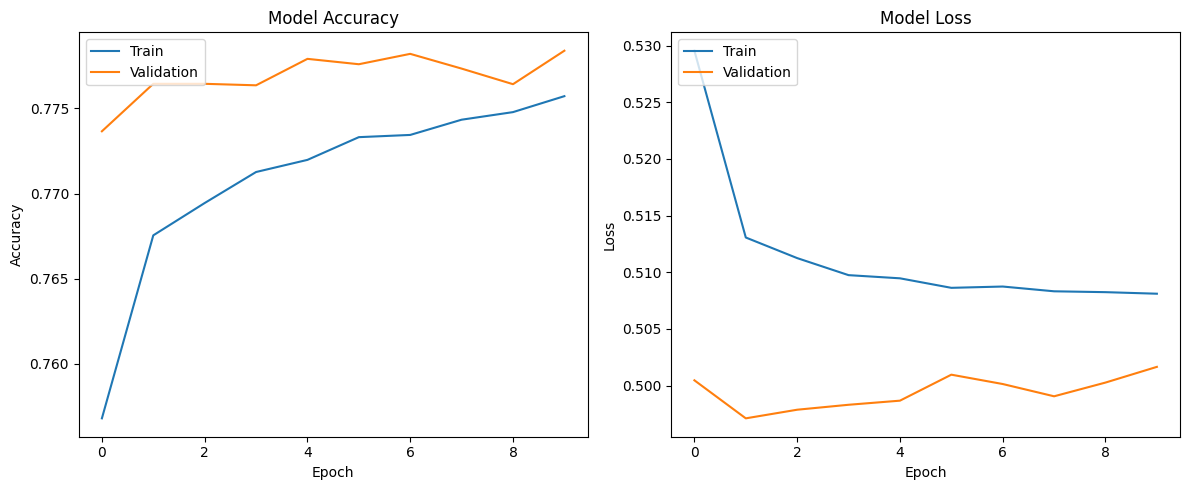

In [90]:
# lower model complexity to prevent overfitting
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) # lower filter to 64 also add l2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) # make dropout rate larger to improve Regularization
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) # switch neurons from 10 to 5
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**The current model's performance on the validation set has improved compared to before. Overfitting has been reduced, and the validation performance is now more stable.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 912us/step - accuracy: 0.7811 - loss: 0.4756
Test Accuracy: 0.7804999947547913


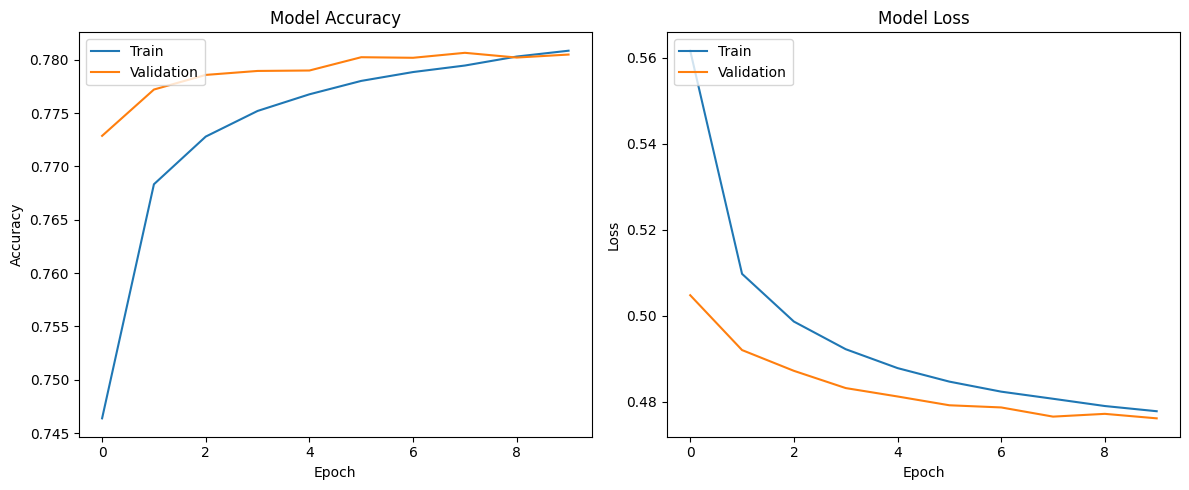

In [93]:
# more tuning to prevent overfitting
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) # lower filter to 64 also add l2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) # make dropout rate larger to improve Regularization
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) # switch neurons from 10 to 5
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model(lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with EarlyStopping
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**It looks better now, the training and validation accuracy have become much closer, indicating that the model is now better generalizing and not overfitting to the training data.
Both training and validation loss show a consistent downward trend, indicating the model is learning effectively.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7298 - loss: 0.5676
Test Accuracy: 0.7303468585014343


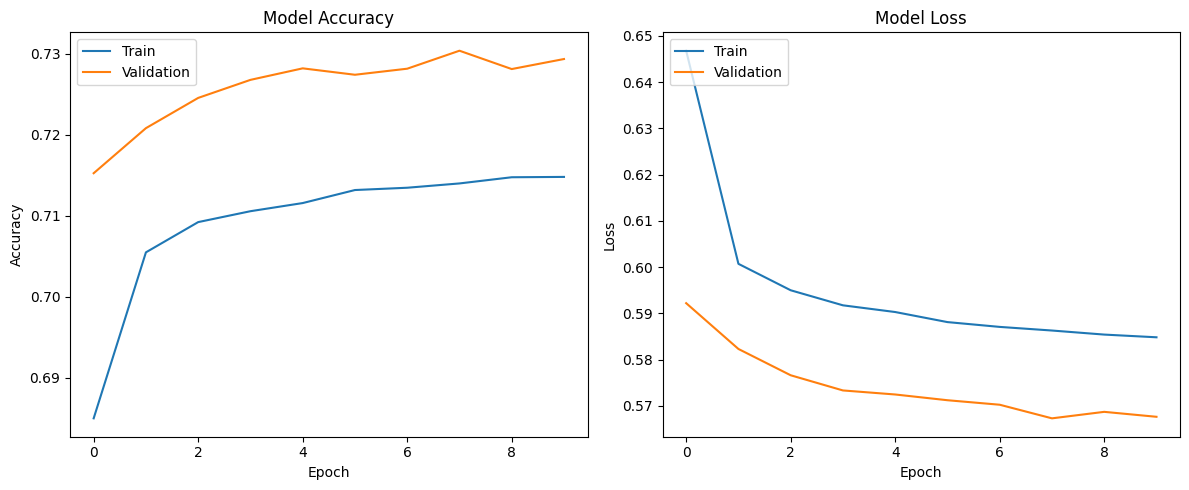

In [94]:
# use pretrained embeddings to improve  model performance (use the best hyperparameter combination so far)
file_path = 'glove.6B.100d.txt'

def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_embeddings = load_glove_embeddings('glove.6B.100d.txt')
word_index = tokenizer.word_index

# Preparing embedding matrix
embedding_dim = 100  # Example for 100-dimensional GloVe
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, 
                    output_dim=embedding_dim, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=False))  # Using pre-trained embeddings
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) 
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) 
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) 
model.add(Dense(1, activation='sigmoid'))  

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

# use early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with EarlyStopping
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Compare with ealier model, using pretrained embeddings didn't imporve model performance**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 8s 831us/step - accuracy: 0.7803 - loss: 0.4752
Test Accuracy: 0.7804812788963318


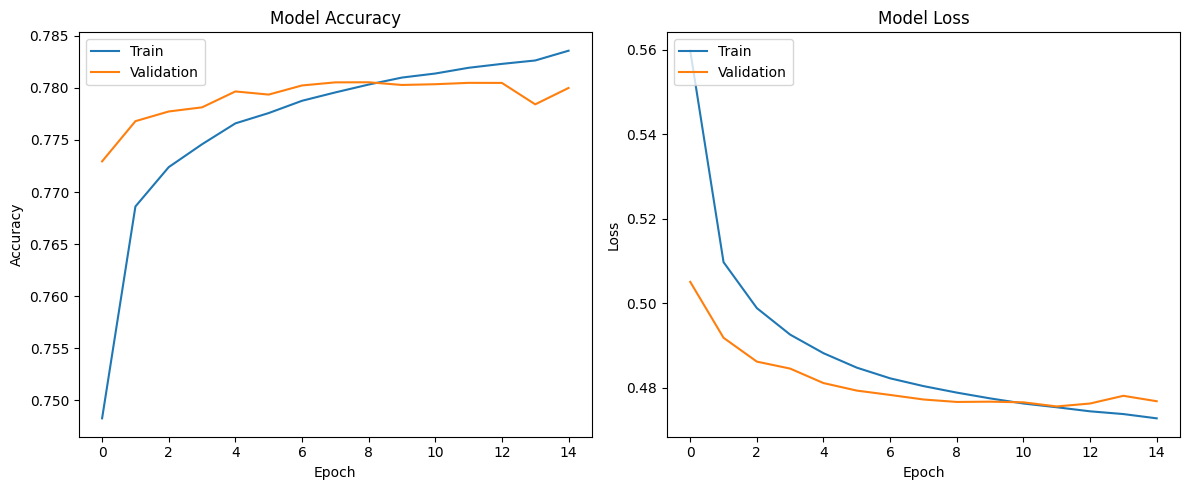

In [95]:
# Increase number of epochs

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) # lower filter to 64 also add l2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) # make dropout rate larger to improve Regularization
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) # switch neurons from 10 to 5
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model(lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 50 # add epochs to 50

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with EarlyStopping
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Too many epochs may cause overfitting, we can tell from the training curve cross the validation curve.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.7783 - loss: 0.5004
Test Accuracy: 0.7779874801635742


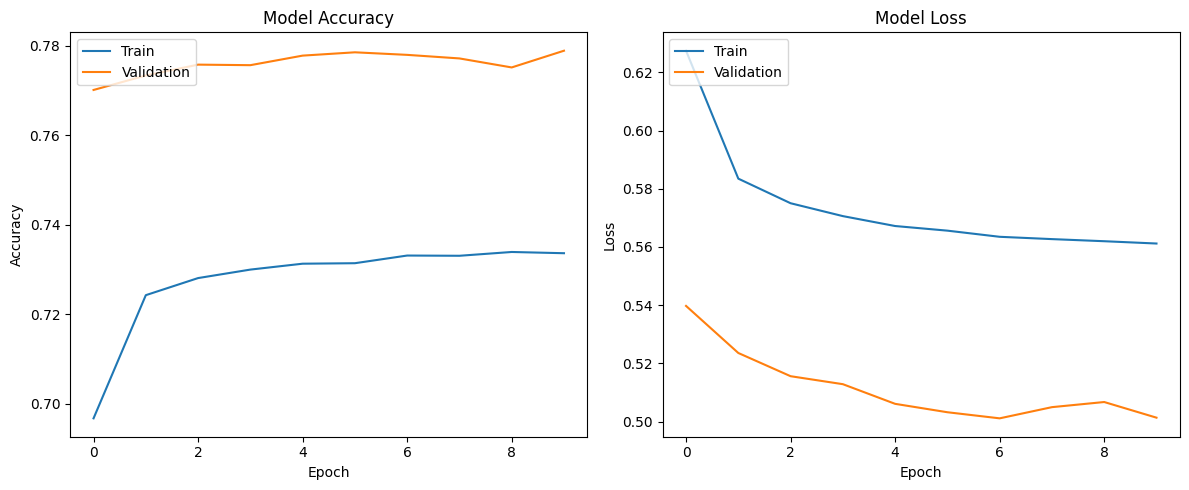

In [111]:
# add dropout layers for better regularization

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) 
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) 
model.add(Dense(5, activation='relu', kernel_regularizer='l2'))
model.add(Dropout(0.6))  # Another dropout layer before output
model.add(Dense(1, activation='sigmoid'))  

# Compile the model(lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with EarlyStopping
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Model didn't improve.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 905us/step - accuracy: 0.7815 - loss: 0.4748
Test Accuracy: 0.7809125185012817


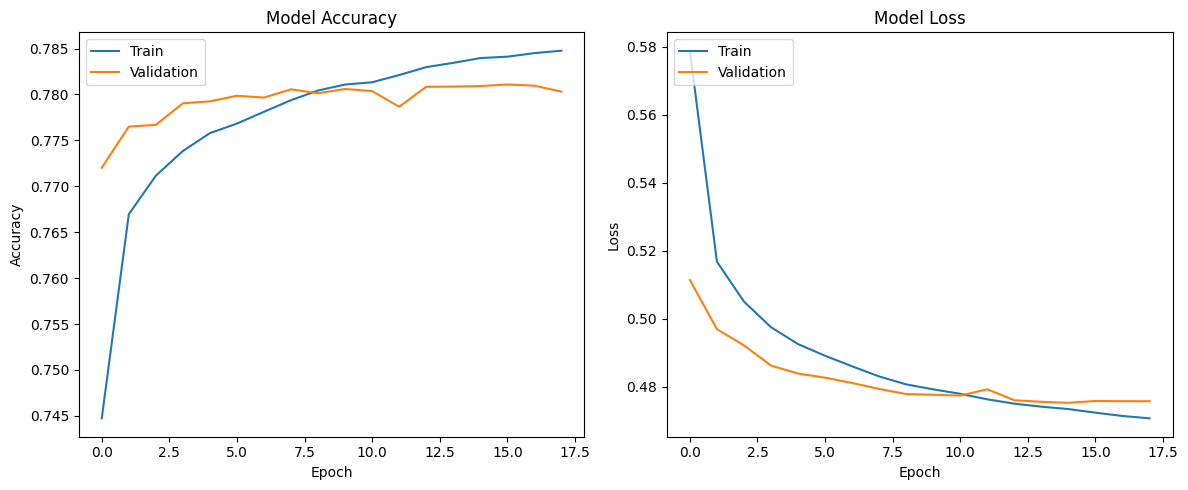

In [114]:
# increase batch size to reduce overfit

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) # lower filter to 64 also add l2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) # make dropout rate larger to improve Regularization
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) # switch neurons from 10 to 5
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model(lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 64  # increase epoch from 32 to 64
epochs = 20 # increase epoch from 10 to 20

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with EarlyStopping
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0, callbacks=[early_stopping])

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**The accuracy curve crossing earlier (at 7.5 epochs) likely indicates that the model's accuracy on the validation set begins to decline at an earlier stage, suggesting that the model starts to "memorize" patterns from the training set too early, instead of generalizing well to the validation set.**

**The loss curve crossing later (around 11 epochs) shows that while the accuracy on the validation set decreases, the model continues to optimize for a few more epochs. However, the loss function becomes less stable, and the validation loss starts to increase. This further confirms overfitting, meaning that the model's predictions are becoming less accurate as it fits more to the training data rather than learning generalizable features.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.7812 - loss: 0.4773
Test Accuracy: 0.7804812788963318


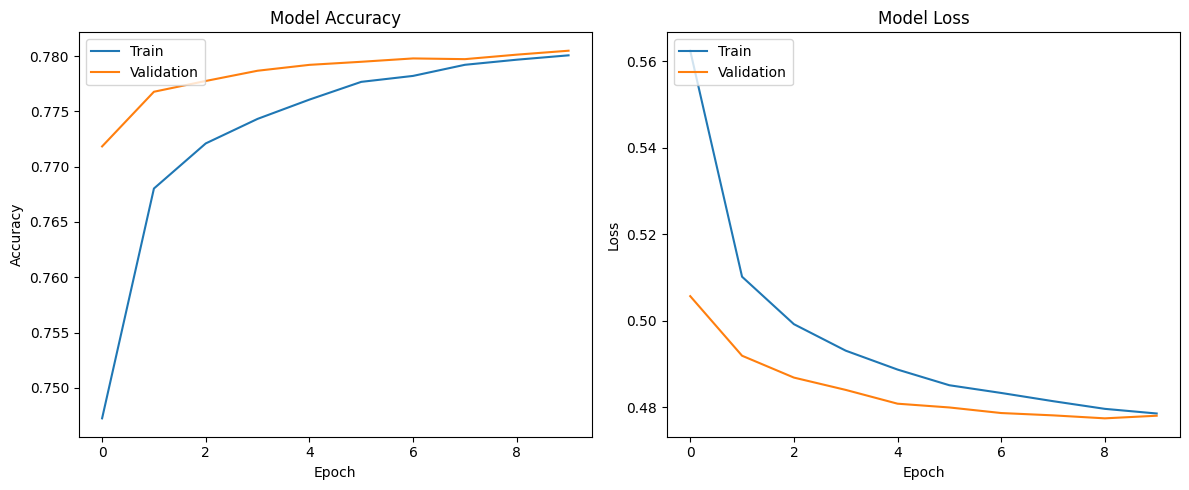

In [120]:
# dynamically change learning rate using ReduceLROnPlateau

# Initialize the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by a factor of 0.5
    patience=3,          # Wait for 3 epochs before reducing the learning rate
    min_lr=1e-6          # Set a minimum learning rate
)

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) # lower filter to 64 also add l2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) # make dropout rate larger to improve Regularization
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) # switch neurons from 10 to 5
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model(lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the ReduceLROnPlateau callback
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[reduce_lr],  # Include the callback
    verbose=0
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

**Model still overfit a bit.**

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 9s 916us/step - accuracy: 0.7746 - loss: 0.5014
Test Accuracy: 0.7747593522071838


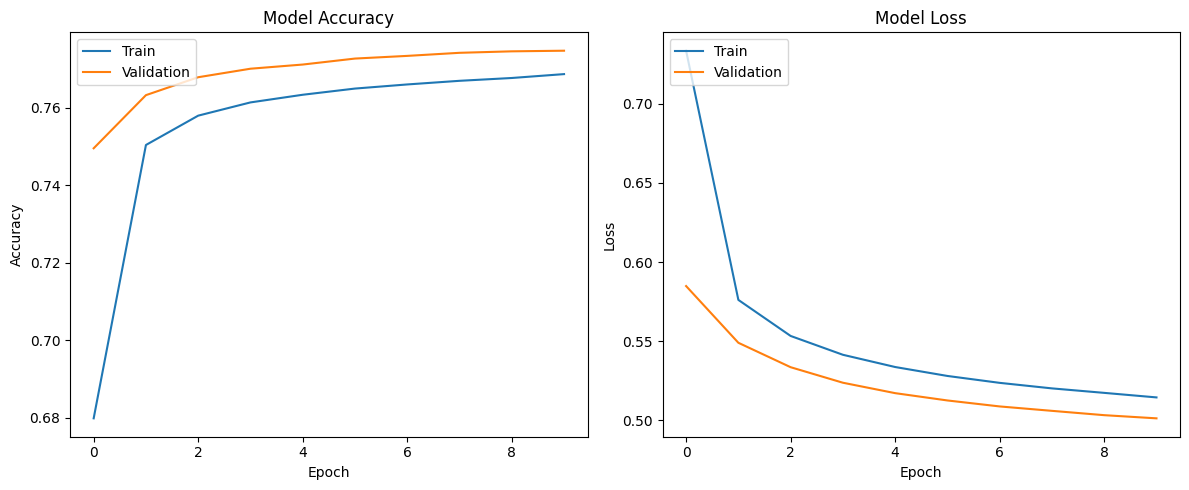

In [124]:
# dynamically change learning rate using ReduceLROnPlateau

# Initialize the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce learning rate by a factor of 0.5
    patience=3,          # Wait for 3 epochs before reducing the learning rate
    min_lr=1e-6          # Set a minimum learning rate
)

model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(filters=64, kernel_size=kernel_size, activation='relu', kernel_regularizer='l2')) # lower filter to 64 also add l2 Regularization
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.6)) # make dropout rate larger to improve Regularization
model.add(Dense(5, activation='relu', kernel_regularizer='l2')) # switch neurons from 10 to 5
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile the model(lower learning rate)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 32
epochs = 10  

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with the ReduceLROnPlateau callback
history = model.fit(
    X_train, 
    y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_data=(X_test, y_test), 
    callbacks=[reduce_lr],  # Include the callback
    verbose=0
)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

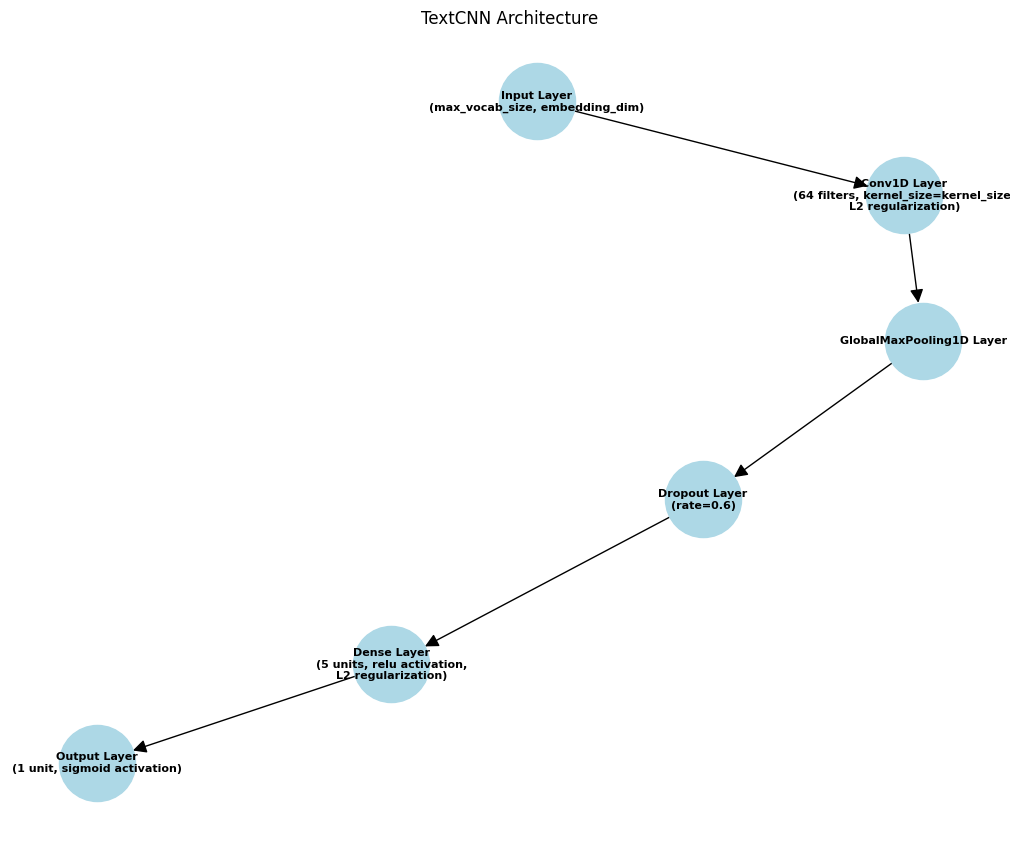

In [151]:
# generate network structure

# Create a graph object
G = nx.DiGraph()

# Add nodes (represent layers)
G.add_node("Input Layer\n(max_vocab_size, embedding_dim)")  # Embedding layer
G.add_node("Conv1D Layer\n(64 filters, kernel_size=kernel_size,\nL2 regularization)")
G.add_node("GlobalMaxPooling1D Layer")
G.add_node("Dropout Layer\n(rate=0.6)")
G.add_node("Dense Layer\n(5 units, relu activation,\nL2 regularization)")
G.add_node("Output Layer\n(1 unit, sigmoid activation)")

# Add edges (represent flow of data)
G.add_edges_from([("Input Layer\n(max_vocab_size, embedding_dim)", "Conv1D Layer\n(64 filters, kernel_size=kernel_size,\nL2 regularization)"),
                  ("Conv1D Layer\n(64 filters, kernel_size=kernel_size,\nL2 regularization)", "GlobalMaxPooling1D Layer"),
                  ("GlobalMaxPooling1D Layer", "Dropout Layer\n(rate=0.6)"),
                  ("Dropout Layer\n(rate=0.6)", "Dense Layer\n(5 units, relu activation,\nL2 regularization)"),
                  ("Dense Layer\n(5 units, relu activation,\nL2 regularization)", "Output Layer\n(1 unit, sigmoid activation)")])

# Draw the network
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Generates the layout for the graph
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold', arrows=True, arrowstyle='-|>', arrowsize=20)
plt.title("TextCNN Architecture")
plt.show()

**The primary goal of sentiment analysis is to ensure that the model generalizes well to new data. Therefore, preventing overfitting should take priority over simply aiming for a higher accuracy. Therefore, this result (accuaracy = 0.77) will be my final result.**

### Project Summary 


**Data Preprocessing**
Cleaned the dataset by removing irrelevant columns, adjusting timestamps, and cleaning the text (removing stopwords, tokenization, stemming). Using **TF-IDF vectorization**, converted the cleaned text into numerical features for model training. Given the large size of the dataset, applied **stratified sampling** to ensure that the data distribution in the sample was consistent with the original dataset, and validated this through distribution comparison.


**Model Development**

- **Shotgun Approach**
  Initially, I used a shotgun approach to evaluate multiple models: **Support Vector Machine (SVM), Logistic Regression, Random Forest, and Naive Bayes**. SVM and Logistic Regression demonstrated the best performance. I then performed **RandomizedSearchCV** and **GridSearchCV** for hyperparameter tuning on both models. However, the performance of Logistic Regression without tuning slightly exceeded the tuned version, so I selected the untuned Logistic Regression as a baseline.

- **Neural Network Development**
  I implemented a **TextCNN** model for sentiment analysis. The initial accuracy was 78%, but significant overfitting was observed. To mitigate overfitting, I introduced **L2 regularization** and **reduced model complexity** (lowering the number of filters, reducing neuron counts in dense layers). This reduced overfitting slightly, but further tuning was needed.
  Next, I added **Dropout** and **Lowered the learning rate** to 0.0001, reaching a more stable performance (accuracy: 77%) with improved generalization. I also tested **GloVe embeddings** for enhanced semantic capture but found no significant improvement. While increasing the **epochs** initially led to better performance, it also caused overfitting as training progressed.


**Challenges and Final Decisions**
After exploring various optimization strategies like **pretrained embeddings**, **dynamic learning rate**, and **early stopping**, I found that **ReduceLROnPlateau** improved the model stability but slightly reduced accuracy to 77%. Considering the overall stability and reduced overfitting, I selected this model as the final result.


### Conclusion and Improvement Suggestions


**Conclusion**
Throughout the project, I explored several strategies to improve sentiment classification, including data preprocessing, feature engineering, and model tuning. My final **TextCNN model**, although slightly overfitting, performed with a stable accuracy of 77%. The combination of **regularization**, **dropout**, and **learning rate adjustments** helped mitigate overfitting.
Despite the efforts with advanced techniques like **pretrained embeddings** and **early stopping**, significant breakthroughs in accuracy beyond 77% were not achieved.


**Improvement Suggestions**
- **Data Augmentation**: More advanced data augmentation techniques such as **back translation** or **synonym replacement** could be explored to generate more varied data for training.
- **Model Structure Enhancement**: Consider integrating **LSTM** or **GRU layers** with CNN to capture more complex contextual information and improve model performance further.
- **Hyperparameter Optimization**: Explore more extensive hyperparameter tuning using methods like **Bayesian optimization** for better parameter selection, potentially reducing overfitting further.

### Business Application

The final model can be applied in several business scenarios such as **customer feedback analysis**, **brand sentiment monitoring**, and **social media trend analysis**. Although the accuracy could be improved, the model provides valuable insights into real-time sentiment trends and can serve as a basis for further enhancement through future fine-tuning or integration into larger business pipelines.

By balancing the trade-off between **accuracy and overfitting**, this model is well-suited for practical sentiment analysis tasks that require reliable yet efficient classification performance.